In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def sin_func(x, a, b, c, phi):
    return (a + b * x) * (np.sin(c * (x - 1310) - phi)) ** 2

def lin_func(x, A, B):
    return A * x ** 2 + B * x

In [3]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'pdk_thermphase_test_cells'

no = 1
data_dir_gen = sorted(data_path.glob(f'reticle27/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    # print(df['wavelength'])
    # ret = int(df['reticle'][0])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]

currs = [i - currs[0] for i in currs] # current should be 0 at 0 V
currs_mA = np.multiply(currs, 1000)

elec_pwrs = np.multiply(volts, currs_mA)
res = np.divide(volts[1:], currs[1:])

print(currs_mA)
print(res)
print(len(currs_mA))

[ 0.         3.9624808  7.8851448 11.8220018 15.6320218 19.3890818
 23.0818818 26.6913718 30.3240218 33.7394118 37.0514418 40.2619818
 43.3654418 46.4572118 49.3389718 52.1235718 54.7866318 57.3475118
 59.8025818 62.2413918 64.4951918 66.6573018 68.7281718 70.7173818
 72.6771818 74.4911618]
[25.23671534 25.36415057 25.37641299 25.58850065 25.78770904 25.99441437
 26.22570339 26.38172487 26.67503528 26.98950301 27.32105949 27.67180386
 27.9827383  28.37513529 28.77776691 29.20420452 29.64383191 30.09903496
 30.52630966 31.01006361 31.50442552 32.01016326 32.52382853 33.02274442
 33.56102844]
26


(1306.0, 1315.0)

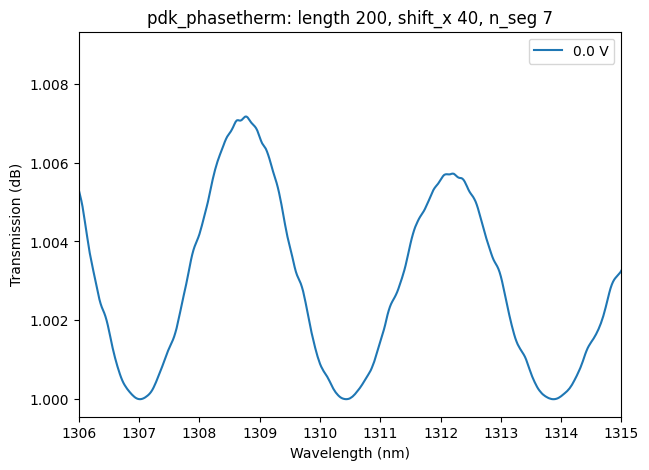

In [4]:
# plot tranmission spectra at different voltages
trans_mW = [10 ** np.divide(tr, 10) for tr in trans]

title = f"pdk_phasetherm: length {df['length'][no]}, shift_x {df['shift_x'][no]}, n_seg {df['n_seg'][no]}"
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [0]:
    ax.plot(wavel, 10 ** np.divide(trans_mW[i], 10), label=f'{volts[i]:.2} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (mW)')
ax.set_title(title)
ax.legend()
ax.set_xlim([1306, 1315])
# ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
[0.4291383684180023, 0.47518404897352245, 0.6402728763366207, 0.9247904829591578, 1.3153583098224622, 1.8211672066112201, nan, 0.13472823203222048, 1.017412576170931, 1.9634610601299867, -0.04055732915507478, 1.137955731797948, 2.4111393352765016, 0.7533568079678437, 2.2015680759832277, 0.7015694861302133, 2.3381457245623944, 0.9963101131685976, -0.29884203897602934, 1.6834037186808404, 0.6111672658176165, -0.45338188809196284, 1.7114049193700005, 0.8733892224659555, 0.14384460664006093, nan]


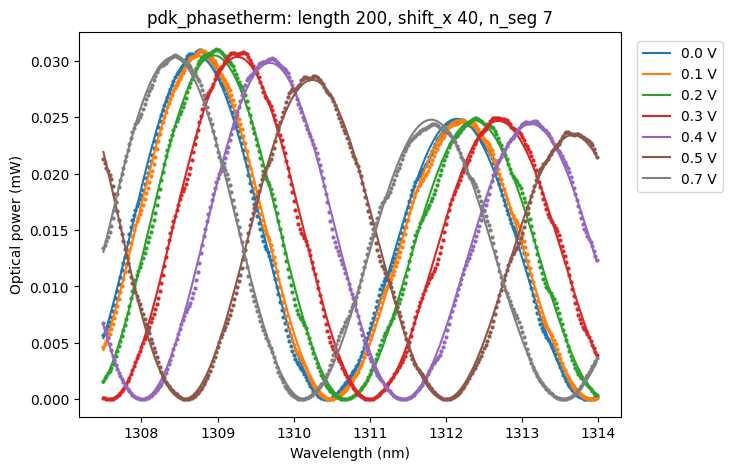

In [5]:
# fit the transmission spectra with the defined function
wl_range = [1307.5, 1314]
idx = [find_index(wl, wavel) for wl in wl_range]
ph_shift_raw = []

# y_predicted = sin_func(x_data, *p_opt)
# residuals = y_data - y_predicted
# ss_total = np.sum((y_data - np.mean(y_data))**2)
# ss_residual = np.sum(residuals**2)
# r_squared = 1 - (ss_residual / ss_total)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
ax = axes
for i in range(len(volts)):  # len(volts)
    print(i)
    if i == 6 or i == 25:
        ph_shift_raw.append(np.nan)
        continue
    x_data, y_data = np.array(wavel[idx[0]:idx[1]]), np.array(trans_mW[i][idx[0]:idx[1]])
    p_opt, p_cov = curve_fit(sin_func, x_data, y_data)
    if i in [0, 1, 2 ,3, 4, 5, 6, 7]:
        ax.plot(x_data, y_data, 'o', markersize=2, color=colors[i%len(colors)])
        ax.plot(x_data, sin_func(x_data, *p_opt), color=colors[i%len(colors)],
                label=f'{volts[i]:.2} V') #, ' + '$\phi$ = ' + f'{p_opt[3]:.2f} rad')
    ph_shift_raw.append(p_opt[3])
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Optical power (mW)')
ax.set_title(title)
ax.legend(bbox_to_anchor = (1.2, 0.78), loc='center right')

print(ph_shift_raw)

[ 0.42913837  0.47518405  0.64027288  0.92479048  1.31535831  1.82116721
  0.13472823  1.01741258  1.96346106 -0.04055733  1.13795573  2.41113934
  0.75335681  2.20156808  0.70156949  2.33814572  0.99631011 -0.29884204
  1.68340372  0.61116727 -0.45338189  1.71140492  0.87338922  0.14384461]


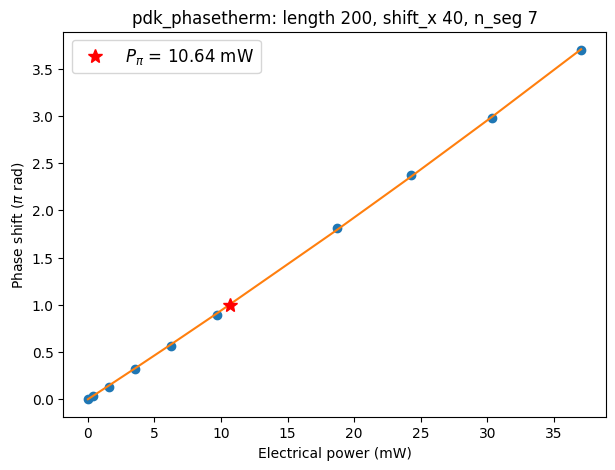

In [6]:
# ph_shift_raw = np.delete(ph_shift_raw, [6, 25])
# print(ph_shift_raw)

ph_shift_single_raw = np.multiply(ph_shift_raw, 2)
ph_shift_single = [ps - ph_shift_single_raw[0] for ps in ph_shift_single_raw]
# unfold the phase shift data
for i in range(1, len(ph_shift_single)):
    if ph_shift_single[i] < ph_shift_single[i-1]:
        ph_shift_single[i:] = [ph + 2*np.pi for ph in ph_shift_single[i:]]

x_data, y_data = elec_pwrs[:11], np.divide(ph_shift_single[:11], np.pi)
# x_data = np.delete(x_data, 6)
p_opt, p_cov = curve_fit(lin_func, x_data, y_data)

p_math = np.roots([*p_opt, -1])
P_pi = p_math[1]
        
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
ax = axes
ax.plot(x_data, y_data, 'o')
ax.plot(x_data, lin_func(x_data, *p_opt))
ax.plot(P_pi, 1, '*', color='r', markersize=10, label='$P_{\pi}$ = ' + f'{P_pi:.2f} mW')
ax.set_xlabel('Electrical power (mW)')
ax.set_ylabel('Phase shift ($\pi$ rad)')
ax.set_title(title)
ax.legend(prop={'size':12})